In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import os
import sys
sys.path.append('../')
import sim
import parse
import run
import plot

PATH_TO_YAML = '../workflows/acp_jung_replication.yaml'

PATH_TO_INPUT_FOLDER = '../secure/acp_jung_replication/'
PATH_TO_PATIENT_PROPERTIES = os.path.join(PATH_TO_INPUT_FOLDER, 'ken_data_for_days.csv')

# Goal

To replicate the graphs in Jung et al. 2021

In [2]:
def assert_jung_replicated(mine_df: pd.DataFrame, 
                           jung_csv_name: str = 'rescue_df',
                           pairs: list[tuple] = [('optimistic', 'Baseline'),]):
    # Ken replicability
    total_differences: int = 0
    ken_df = pd.read_csv(f"~/Downloads/kjung_cost_benefit-master-replication/exact_output/{jung_csv_name}.csv")
    print('Ken labels:', ken_df['Group'].unique())
    print('My labels:', mine_df['label'].unique())
    for pair in pairs:
        mine = mine_df[mine_df['label'] == pair[0]]['mean_utility'].values
        ken = ken_df[ken_df['Group'] == pair[1]]['mean_utility'].values
        n_diff = np.sum(np.round_(mine, 6) != np.round_(ken, 6))
        print('# of differences:', n_diff)
        total_differences += n_diff
    assert total_differences == 0, f"# of total differences is: {total_differences}"

# Load the Workflow

Load our workflow from the YAML file:

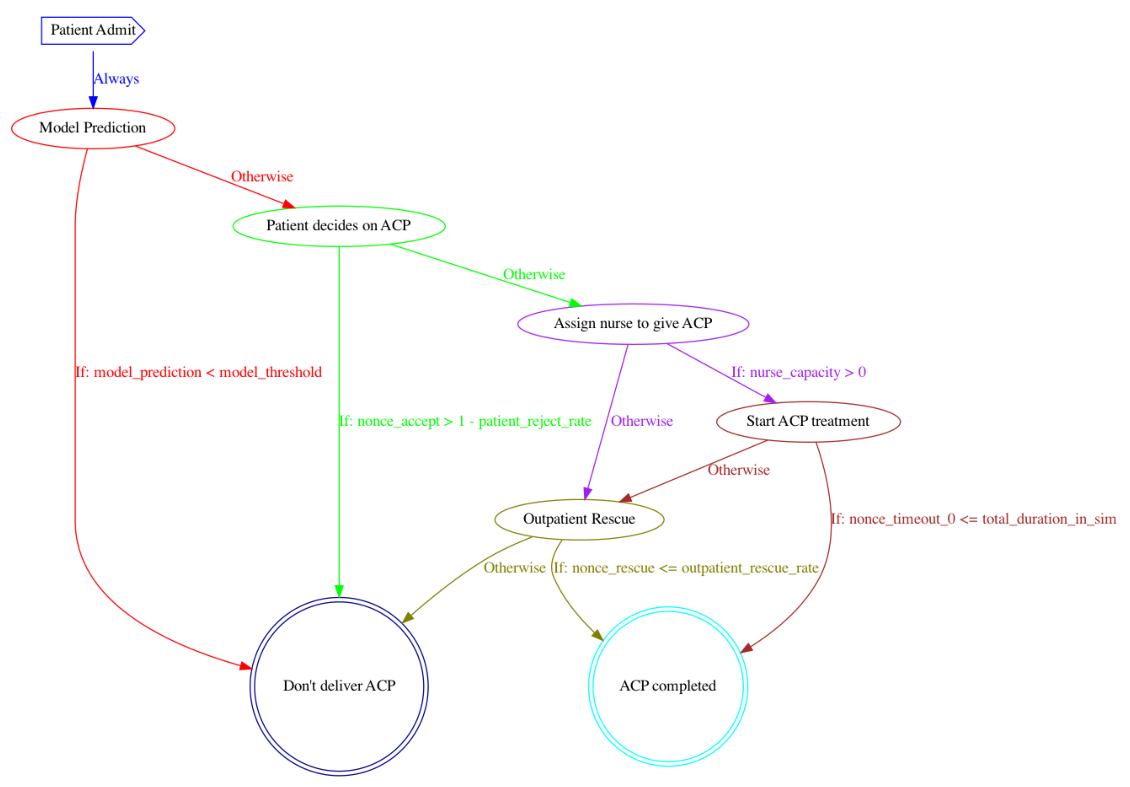

In [5]:
yaml = parse.load_yaml(PATH_TO_YAML)
simulation = parse.create_simulation_from_yaml(yaml)
simulation.metadata['path_to_properties'] = PATH_TO_PATIENT_PROPERTIES
simulation.draw_workflow_diagram()

# Load Patients + Model Predictions

First, we'll load the CSV containing our patients from `ken_data_for_days.csv`.

Next, we initialize a `Patient` object for each row of our CSV, and store these objects in a list called `all_patients`.

Finally, we add each patient's properties to their `Patient` object.

In [6]:
df_patients = pd.read_csv(PATH_TO_PATIENT_PROPERTIES)
f"Shape of df: {df_patients.shape}"

all_patients: list[sim.Patient] = [ 
                                   sim.Patient(
                                        row['id'],
                                        row['day'],
                                    ) 
                                   for _, row in df_patients.iterrows() 
                                ]

all_patients = sim.create_patients_for_simulation(simulation, 
                                                all_patients,
                                                random_seed = 0)
all_patients[0].properties

{'model_prediction': 0.0485028243335557,
 'total_duration_in_sim': 2,
 'patient_id': 0,
 'nonce_accept': 0.842263476923108,
 'nonce_rescue': 0.786526422249153,
 'nonce_timeout_0': 0,
 'nonce_timeout_1': 1.03531088083451,
 'nonce_timeout_2': 5.19398545076079,
 'nonce_timeout_3': 4.86679210488625,
 'nonce_timeout_4': 3.86699107272511,
 'nonce_timeout_100': 23.5839109867811,
 'ground_truth': 0}

# Run Simulations

Let's test different settings for the ACP workflow.

First, we write a function `reset_simulation()` that will reset our simulation to its "default" state between runs.

In [5]:
def reset_simulation(simulation: sim.Simulation, 
                     patients: list[sim.Patient],
                     random_seed: int = 0):
    # Reset simulation to "optimistic" case
    simulation.variables['outpatient_rescue_rate']['value'] = 0
    simulation.variables['nurse_capacity']['init_amount'] = 1e5
    simulation.variables['nurse_capacity']['max_amount'] = 1e5
    simulation.variables['nurse_capacity']['refill_amount'] = 1e5
    simulation.variables['nurse_capacity']['refill_duration'] = 1
    simulation.variables['acp_completion_time']['value'] = 0
    simulation.variables['model_threshold']['value'] = 0.5
    simulation.variables['patient_reject_rate']['value'] = 0
    simulation.states['timeout_func'].transitions[0]._if = 'acp_completion_time <= total_duration_in_sim'
    # Resets patients to "optimistic" case
    # NOTE: This is necessary b/c simulation properties can change, which affects patients
    patients = sim.create_patients_for_simulation(simulation, 
                                                patients,
                                                random_seed = random_seed)
    return patients

Next, we need to specify the model thresholds we want to test

In [6]:
# THRESHOLDS = np.linspace(0, 1, 21)
THRESHOLDS = ([0] + list(np.unique([p.properties['model_prediction'] for p in all_patients])) + [1])

And save the utilities

In [8]:
UTILITIES = {
    'tp' : simulation.variables['utility_true_positive']['value'],
    'fp' : simulation.variables['utility_false_positive']['value'],
    'tn' : simulation.variables['utility_true_negative']['value'],
    'fn' : simulation.variables['utility_false_negative']['value'],
}

## Baseline Model

Next, we need to establish a baseline model -- we'll use the "optimistic" case where all model predictions are actionable.

In [ ]:
all_patients = reset_simulation(simulation, all_patients)
baseline_df = run.test_diff_thresholds(simulation, all_patients, THRESHOLDS, positive_outcome_state_ids=['complete_acp'])
baseline_df['label'] = 'optimistic'

In [8]:
# Ken replicability
assert_jung_replicated(baseline_df, 'baseline_df',
                       [
                           ('optimistic', 'Baseline'),
                       ])

Ken labels: ['Baseline']
My labels: ['optimistic']
# of differences: 0


## Rejection Rate

Goal: Measure how different rejection rates affect our model's utility.

In [ ]:
all_patients = reset_simulation(simulation, all_patients)
values = [.1, .2, .3, ]
rejection_df = run.run_test(simulation, all_patients, 
         [f"{int(x * 100)}%" for x in values ],
         [{
             'patient_reject_rate' : {
                 **simulation.variables['patient_reject_rate'],
                 'value' : x,
             }
         } for x in values ],
         baseline_df, 
         lambda sim, patients, label: run.test_diff_thresholds(sim, patients, THRESHOLDS, positive_outcome_state_ids=['complete_acp']))

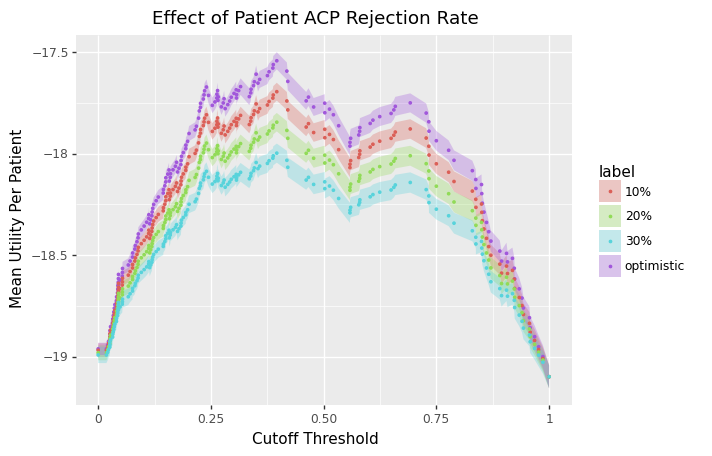

<ggplot: (323923372)>

In [10]:
plot.plot_mean_utility_v_threshold('Patient ACP Rejection Rate', rejection_df)

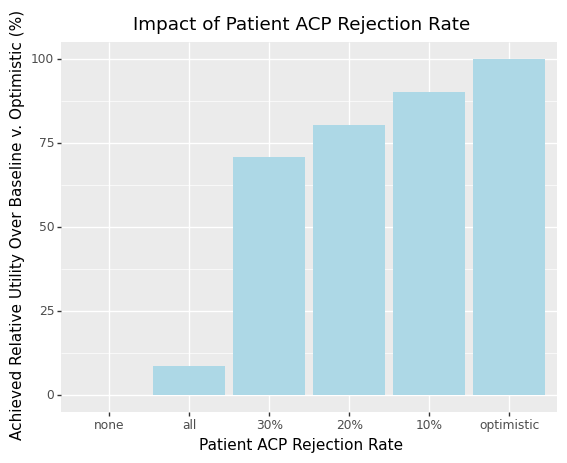

<ggplot: (323998739)>

In [11]:
plot_avg_utilities = {
    label: rejection_df[rejection_df['label'] == label]['mean_utility'].max() for label in rejection_df['label'].unique()
} | sim.get_unit_utility_baselines(all_patients, UTILITIES)
plot.plot_bar_mean_utilities('Patient ACP Rejection Rate', plot_avg_utilities)

In [12]:
# Ken replicability
assert_jung_replicated(rejection_df, 'rejection_df',
                       [
                           ('optimistic', 'Baseline'),
                           ('10%', 'Reject 10%'),
                           ('20%', 'Reject 20%'),
                           ('30%', 'Reject 30%'),
                       ])

Ken labels: ['Baseline' 'Reject 100%' 'Reject 30%' 'Reject 20%' 'Reject 10%'
 'Reject 0%']
My labels: ['optimistic' '10%' '20%' '30%']
# of differences: 0
# of differences: 0
# of differences: 0
# of differences: 0


## Capacity Constraint

Goal: Measure how changing the number of patients that can go through ACP each day impacts model utility.

In [ ]:
all_patients = reset_simulation(simulation, all_patients)
values = [ 0, 1, 2, 3, 4, 5, ]
cap_df = run.run_test(simulation, all_patients, 
         [f"{x}" for x in values ],
         [{
             'nurse_capacity' : {
                 **simulation.variables['nurse_capacity'],
                 'init_amount' : x,
                 'max_amount' : x,
                 'refill_amount' : x,
             }
         } for x in values ],
         baseline_df, 
         lambda sim, patients, label : run.test_diff_thresholds(sim, patients, THRESHOLDS, positive_outcome_state_ids=['complete_acp']))

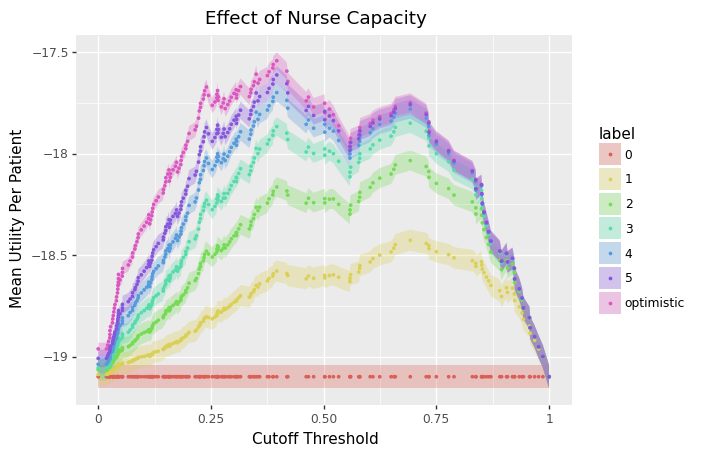

<ggplot: (323084599)>

In [14]:
plot.plot_mean_utility_v_threshold('Nurse Capacity', cap_df)

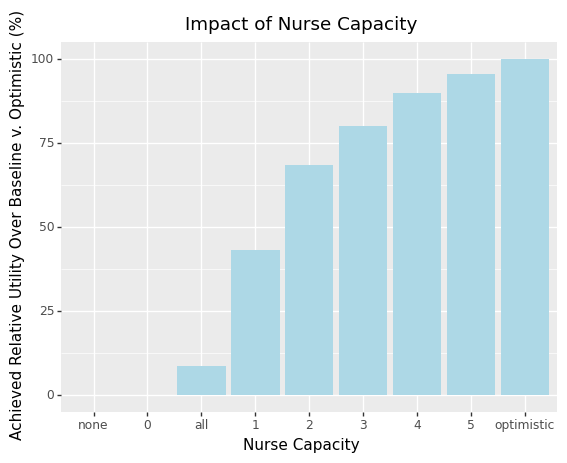

<ggplot: (337793693)>

In [15]:
plot_avg_utilities = {
    label: cap_df[cap_df['label'] == label]['mean_utility'].max() for label in cap_df['label'].unique()
} | sim.get_unit_utility_baselines(all_patients, UTILITIES)
plot.plot_bar_mean_utilities('Nurse Capacity', plot_avg_utilities)

In [16]:
# Ken replicability
assert_jung_replicated(cap_df, 'cap_df',
                       [
                           ('optimistic', 'Baseline'),
                           ('0', 'Daily capacity = 0'),
                           ('1', 'Daily capacity = 1'),
                           ('2', 'Daily capacity = 2'),
                           ('3', 'Daily capacity = 3'),
                           ('4', 'Daily capacity = 4'),
                           ('5', 'Daily capacity = 5'),
                       ])

Ken labels: ['Baseline' 'Daily capacity = 0' 'Daily capacity = 1' 'Daily capacity = 2'
 'Daily capacity = 3' 'Daily capacity = 4' 'Daily capacity = 5'
 'Daily capacity = 100']
My labels: ['optimistic' '0' '1' '2' '3' '4' '5']
# of differences: 0
# of differences: 0
# of differences: 0
# of differences: 0
# of differences: 0
# of differences: 0
# of differences: 0


## ACP Timeout

Goal: Measure how changing the mean time to complete ACP affects model utility.

In [ ]:
all_patients = reset_simulation(simulation, all_patients)
values = [ 1, 2, 3, 4, ]
def _run_timeout(sim, patients, label):
    sim.states['timeout_func'].transitions[0]._if = f"nonce_timeout_{label} <= total_duration_in_sim"
    return run.test_diff_thresholds(sim, patients, THRESHOLDS, positive_outcome_state_ids=['complete_acp'])
timeout_df = run.run_test(simulation, all_patients,
         [f"{x}" for x in values ],
         [{
         } for x in values ],
         baseline_df, 
         _run_timeout)

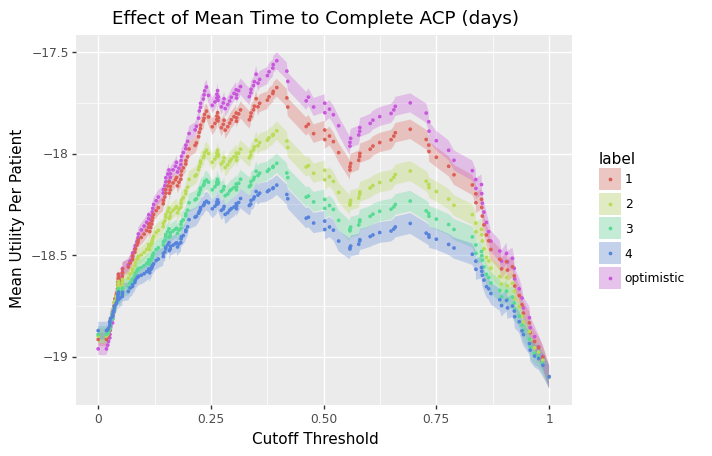

<ggplot: (341641382)>

In [41]:
plot.plot_mean_utility_v_threshold('Mean Time to Complete ACP (days)', timeout_df)

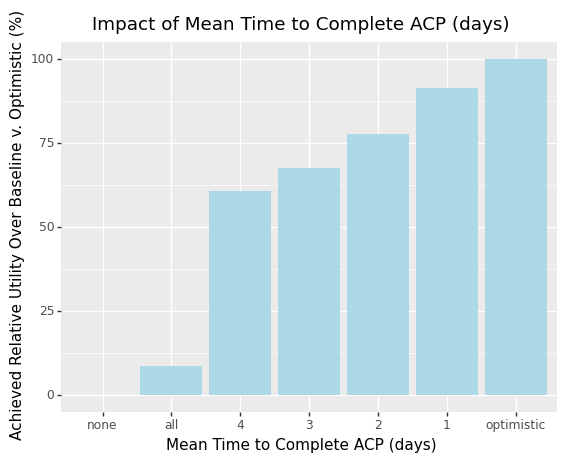

<ggplot: (320357416)>

In [42]:
plot_avg_utilities = {
    label: timeout_df[timeout_df['label'] == label]['mean_utility'].max() for label in timeout_df['label'].unique()
} | sim.get_unit_utility_baselines(all_patients, UTILITIES)
plot.plot_bar_mean_utilities('Mean Time to Complete ACP (days)', plot_avg_utilities)

In [40]:
# Ken replicability
assert_jung_replicated(timeout_df, 'timeout_df',
                       [
                           ('optimistic', 'Baseline'),
                           ('1', 'Time required = 1 day'),
                           ('2', 'Time required = 2 day'),
                           ('3', 'Time required = 3 day'),
                           ('4', 'Time required = 4 day'),
                       ])

Ken labels: ['Baseline' 'Time required = 0 day' 'Time required = 1 day'
 'Time required = 2 day' 'Time required = 3 day' 'Time required = 4 day'
 'Time required = 100 day']
My labels: ['optimistic' '1' '2' '3' '4']
# of differences: 0
# of differences: 0
# of differences: 0
# of differences: 0
# of differences: 0


## Outpatient Rescue

Goal: Test how changing the outpatient rescue rate affects model utility.

In [ ]:
all_patients = reset_simulation(simulation, all_patients)
simulation.variables['nurse_capacity']['init_amount'] = 3
simulation.variables['nurse_capacity']['max_amount'] = 3
simulation.variables['nurse_capacity']['refill_amount'] = 3
simulation.variables['patient_reject_rate']['value'] = 0.1
simulation.states['timeout_func'].transitions[0]._if = f"nonce_timeout_2 <= total_duration_in_sim"
values = [ 0, 0.5, 1, ]
rescue_df = run.run_test(simulation, all_patients,
         [f"{int(100 * x)}%" for x in values ],
         [{
             'outpatient_rescue_rate' : {
                 **simulation.variables['outpatient_rescue_rate'],
                 'value' : x,
             }
         } for x in values ],
         baseline_df, 
         lambda sim, patients, label: run.test_diff_thresholds(sim, patients, THRESHOLDS, positive_outcome_state_ids=['complete_acp']))

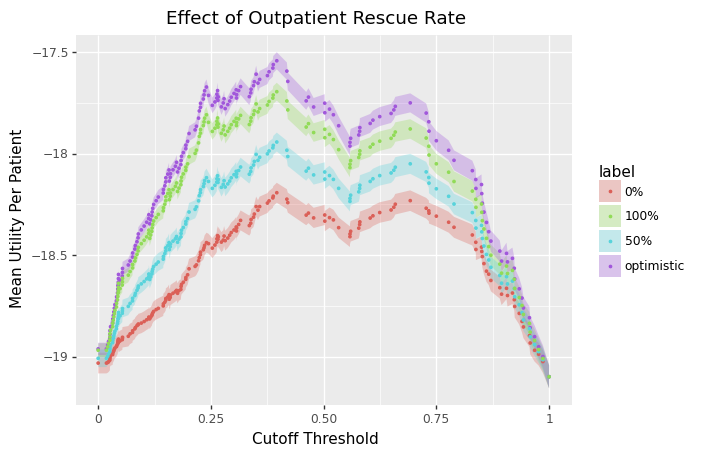

<ggplot: (340194753)>

In [44]:
plot.plot_mean_utility_v_threshold('Outpatient Rescue Rate', rescue_df)

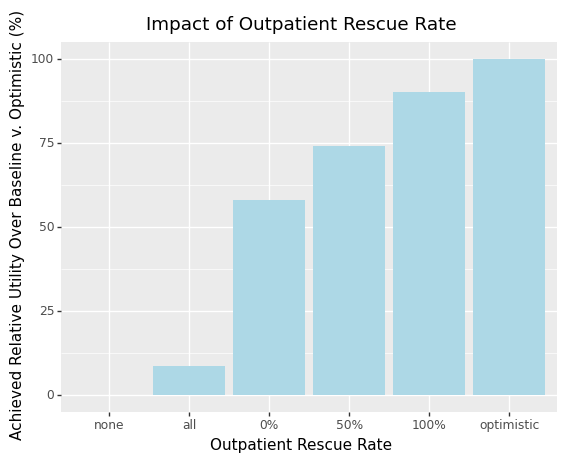

<ggplot: (331471586)>

In [45]:
plot_avg_utilities = {
    label: rescue_df[rescue_df['label'] == label]['mean_utility'].max() for label in rescue_df['label'].unique()
} | sim.get_unit_utility_baselines(all_patients, UTILITIES)
plot.plot_bar_mean_utilities('Outpatient Rescue Rate', plot_avg_utilities)

In [46]:
assert_jung_replicated(rescue_df, 'rescue_df',
                       [
                           ('optimistic', 'Baseline'),
                           ('0%', 'Rescue 0%'),
                           ('50%', 'Rescue 50%'),
                           ('100%', 'Rescue 100%'),
                       ])

Ken labels: ['Baseline' 'Rescue 0%' 'Rescue 50%' 'Rescue 100%']
My labels: ['optimistic' '0%' '50%' '100%']
# of differences: 0
# of differences: 0
# of differences: 0
# of differences: 0


# Measure Model Utility

Print plots summarizing model utilities

[0.04850282 0.3383535  0.19840354 ... 0.1446933  0.53338998 0.04522008]


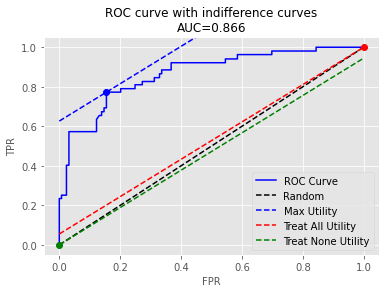

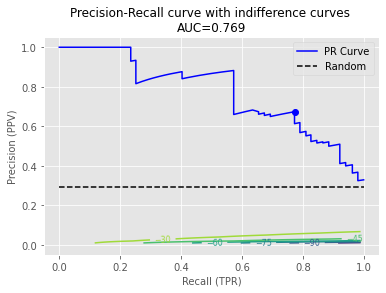

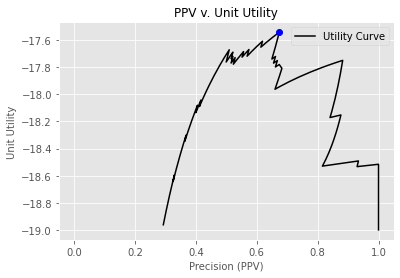

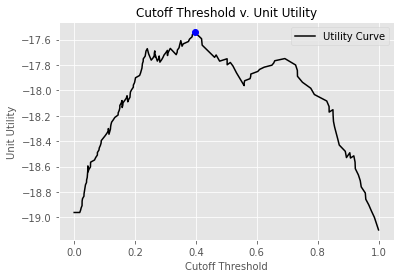

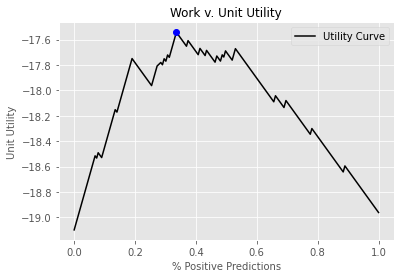

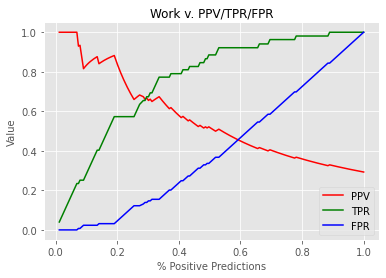

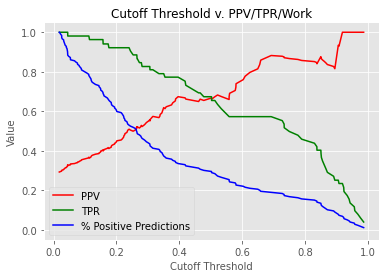

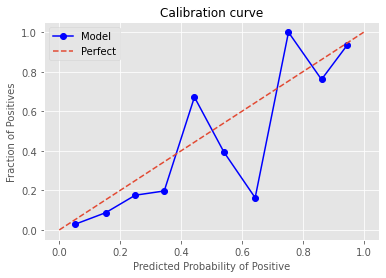

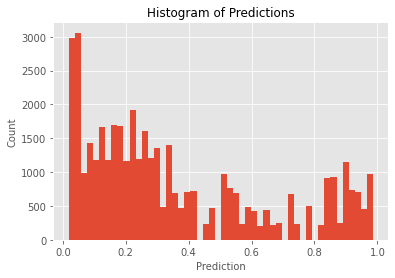

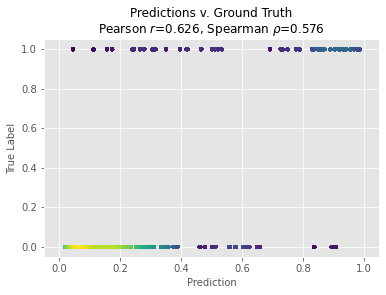

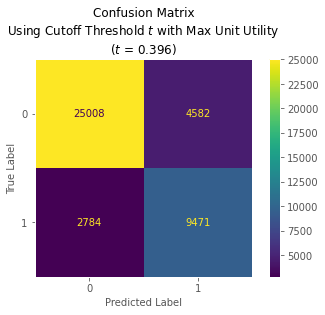

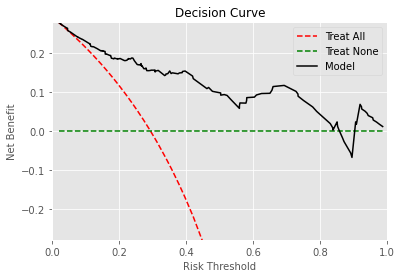

In [10]:
plot.make_model_utility_plots(df_patients, UTILITIES, is_show = True)

# Line graph (Figure 2)

In [ ]:
all_patients = reset_simulation(simulation, all_patients)
simulation.variables['patient_reject_rate']['value'] = 0.1
simulation.states['timeout_func'].transitions[0]._if = f"nonce_timeout_2 <= total_duration_in_sim"
values = [ 0, 0.5, 1, ]
capacity_values = [ 1, 2, 3, 4, 5, ]
rescue_values = [ 0, 0.5, 1, ]
combined_df = run.run_test(simulation, all_patients,
         [f"{x},{y}" for x in capacity_values for y in rescue_values],
         [{
             'outpatient_rescue_rate' : {
                 **simulation.variables['outpatient_rescue_rate'],
                 'value' : y,
             },
             'nurse_capacity' : {
                 **simulation.variables['nurse_capacity'],
                 'init_amount' : x,
                 'max_amount' : x,
                 'refill_amount' : x,
             }
         } for x in capacity_values for y in rescue_values ],
         baseline_df, 
         lambda sim, patients, label: run.test_diff_thresholds(sim, patients, THRESHOLDS, positive_outcome_state_ids=['complete_acp']))

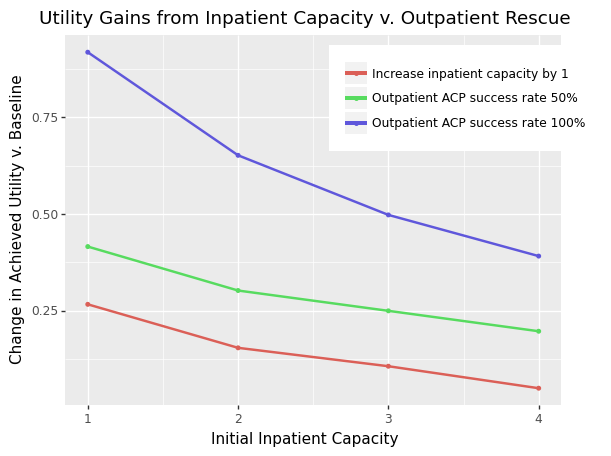

<ggplot: (328639567)>

In [98]:
df = combined_df.groupby('label', as_index=False).agg({
    'label' : 'first',
    'mean_utility' : 'max',
})
rows = []
for idx, row in df.iterrows():
    if row['label'] == 'optimistic': continue
    capacity = int(row['label'].split(',')[0])
    rescue_rate = float(row['label'].split(',')[1])
    if rescue_rate != 0:
        baseline_utility = df[df['label'] == f"{capacity},0"]['mean_utility'].values[0]
        if capacity > 4: 
            continue
        rows.append({
            'line' : f"rescue={rescue_rate}",
            'x' : capacity,
            'y' : row['mean_utility'] - baseline_utility,
        })
    else:
        if capacity > 1:
            baseline_utility = df[df['label'] == f"{capacity - 1},0"]['mean_utility'].values[0]
            rows.append({
                'line' : f"capacity=+1",
                'x' : capacity - 1,
                'y' : row['mean_utility'] - baseline_utility,
            })
df = pd.DataFrame(rows)

plot.plot_line_compare_multiple_settings('Utility Gains from Inpatient Capacity v. Outpatient Rescue',
                                         df,
                                         'Initial Inpatient Capacity',
                                         ['Increase inpatient capacity by 1',
                                          'Outpatient ACP success rate 50%',
                                          'Outpatient ACP success rate 100%',
                                          ])
        